In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.tree import DecisionTreeClassifier

def make_spirals(n_samples=500, noise=0.1, random_state=42):
    """Generuje dane w ksztalcie spiral ."""
    np.random.seed(random_state)
    n = n_samples // 2
    theta = np.linspace(0, 4 * np.pi, n)
    r = theta / (4 * np.pi)
    x1 = r * np.cos(theta) + noise * np.random.randn(n)
    y1 = r * np.sin(theta) + noise * np.random.randn(n)
    x2 = -r * np.cos(theta) + noise * np.random.randn(n)
    y2 = -r * np.sin(theta) + noise * np.random.randn(n)
    X = np.vstack([np.column_stack([x1, y1]), np.column_stack([x2, y2])])
    y = np.array([0] * n + [1] * n)
    return X, y


def plot_decision_boundary(model, X, y, ax, title=""):
    """Rysuje granice decyzyjna modelu ."""
    h = 0.02  # krok siatki
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlBu")
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="RdYlBu", edgecolors="black")
    ax.set_title(title)

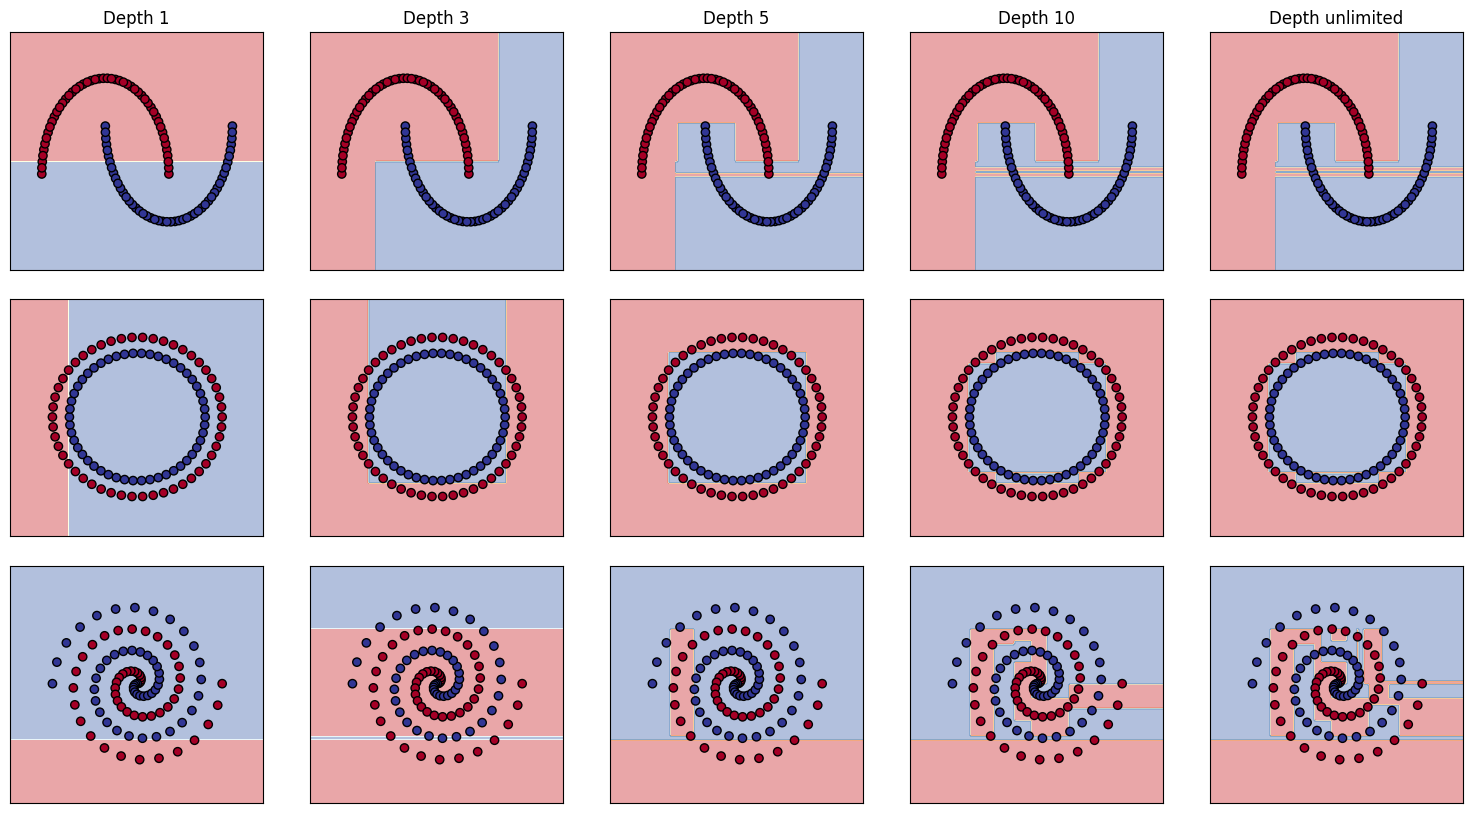

In [2]:
fig, axarr = plt.subplots(3, 5, figsize=(15, 8))
fig.tight_layout(pad=0)

for i, dataset in enumerate([make_moons, make_circles, make_spirals]):
    X, y = dataset(n_samples=100, noise=0.0, random_state=42)
    
    for j, depth in enumerate([1, 3, 5, 10, None]):
        tree = DecisionTreeClassifier(max_depth=depth)
        tree.fit(X, y)
        plot_decision_boundary(tree, X, y, axarr[i, j])
        axarr[i, j].set_xticks([])
        axarr[i, j].set_yticks([])
    
for depth, ax in zip([1, 3, 5, 10, "unlimited"], axarr[0]):
    ax.set_title(f"Depth {depth}")

plt.show()

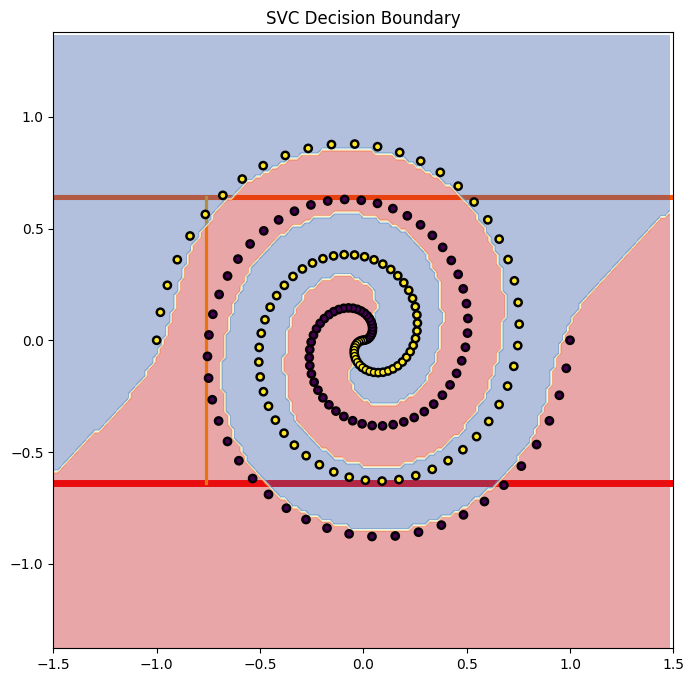

In [3]:
from sklearn.svm import SVC

def visualize_tree_splits(tree, X, y, ax):
    """Wizualizuje kolejne podziały drzewa."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    cmap = plt.get_cmap('autumn')
    max_depth = tree.get_depth()
    
    def recurse(node_id, x_range, y_range, depth):
        feature = tree.tree_.feature[node_id]
        threshold = tree.tree_.threshold[node_id]
        
        linewidth = 1 + 4 * depth / max_depth
        color = cmap(1 - depth / max_depth) if max_depth > 0 else cmap(1)
        
        if feature == -2: return

        if feature == 0:
            ax.plot([threshold, threshold], y_range, '-', linewidth=linewidth, color=color, zorder=1)
            recurse(tree.tree_.children_left[node_id], (x_range[0], threshold), y_range, depth-1)
            recurse(tree.tree_.children_right[node_id], (threshold, x_range[1]), y_range, depth-1)
            
        elif feature == 1:
            ax.plot(x_range, [threshold, threshold], '-', linewidth=linewidth, color=color, zorder=1)
            recurse(tree.tree_.children_left[node_id], x_range, (y_range[0], threshold), depth-1)
            recurse(tree.tree_.children_right[node_id], x_range, (threshold, y_range[1]), depth-1)

    recurse(0, (x_min, x_max), (y_min, y_max), max_depth)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=20, zorder=2)
  
  
X, y = make_spirals(n_samples=200, noise=0.0, random_state=42)
tree = DecisionTreeClassifier(max_depth=3).fit(X, y)

fig, ax = plt.subplots(figsize=(8, 8))

visualize_tree_splits(tree, X, y, ax)

svc = SVC(kernel='rbf', C=500).fit(X, y)
plot_decision_boundary(svc, X, y, ax, title="SVC Decision Boundary")

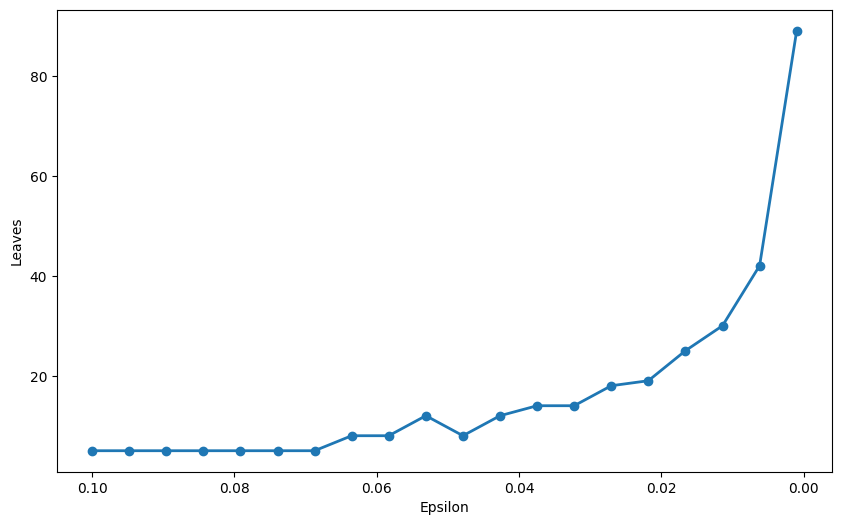

In [4]:
def count_splits_for_circle(radius, tolerance):
    """Liczy ile podzialow potrzeba do aproksymacji okregu ."""
    limit = radius * 1.5
    X = np.random.uniform(-limit, limit, size=(10000, 2))
    
    y = (X[:, 0]**2 + X[:, 1]**2) <= radius**2
    
    current_leaves = 2
    step = 1
    
    while True:
        tree = DecisionTreeClassifier(max_leaf_nodes=current_leaves, random_state=42)
        tree.fit(X, y)
        y_pred = tree.predict(X)
        error = 1 - np.mean(y == y_pred)
        
        if error <= tolerance: return current_leaves
                
        current_leaves += step

tolerances = np.linspace(0.1, 1e-3, 20)
results = []

for t in tolerances:
    l = count_splits_for_circle(radius=1.0, tolerance=t)
    results.append(l)
    
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tolerances, results, 'o-', linewidth=2)
ax.set_xlabel("Epsilon")
ax.set_ylabel("Leaves")
ax.invert_xaxis()

plt.show()

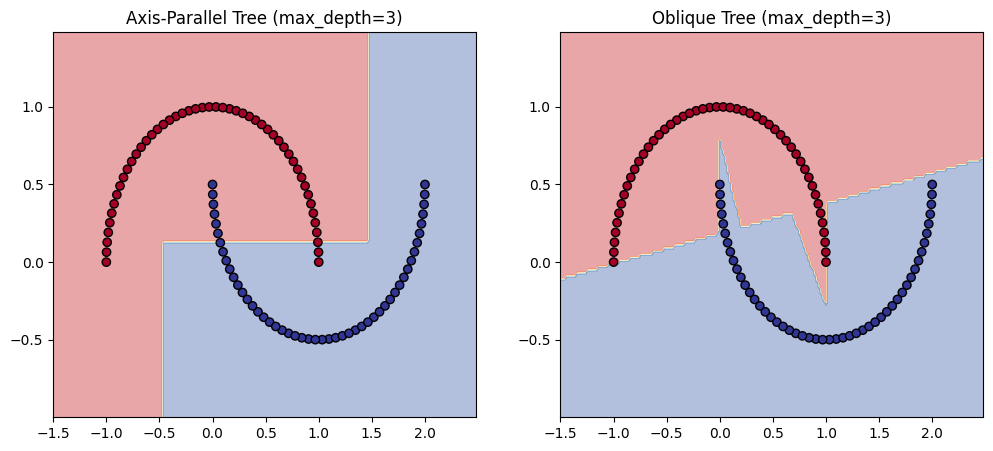

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons

class ObliqueTree(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=3, samples_per_split=20, min_samples_split=2, random_state=None):
        self.max_depth = max_depth
        self.samples_per_split = samples_per_split
        self.min_samples_split = min_samples_split
        self.rng = np.random.RandomState(random_state)

    def fit(self, X, y):
        self.tree_ = self._grow_tree(X, y, depth=self.max_depth)
        return self
    
    def find_best_split(self, x, y):
        x = x[:, None]
        tree = DecisionTreeClassifier(max_depth=1, random_state=self.rng)
        tree.fit(x, y)
        
        not_found = tree.tree_.node_count < 3
        t = tree.tree_.threshold[0]
        return not_found, t, 1 - tree.score(x, y)
        
    def _grow_tree(self, X, y, depth):
        size, n_feat = X.shape
        n_labels = len(np.unique(y))

        if (n_labels == 1) or depth == 0 or (size < self.min_samples_split):
            return {"class": np.argmax(np.bincount(y))}

        best_score, best_split = float('inf'), None

        samples = self.rng.randn(self.samples_per_split, n_feat)
        candidates = np.concatenate([np.eye(n_feat), samples], axis=0)

        for coefs in candidates:
            X_proj = X @ coefs
            not_found, t, impurity = self.find_best_split(X_proj, y)
            
            if not_found:
                continue
            
            if impurity < best_score:
                best_score = impurity
                best_split = {"coefs": coefs, "threshold": t, "left_idx": X_proj <= t, "right_idx": X_proj > t}

        if best_split is None: 
            return {"class": np.argmax(np.bincount(y))}

        best_split["left"] = self._grow_tree(X[best_split["left_idx"]], y[best_split["left_idx"]], depth - 1)
        best_split["right"] = self._grow_tree(X[best_split["right_idx"]], y[best_split["right_idx"]], depth - 1)
        return best_split

    def predict(self, X):
        return np.array([self._predict_one(row, self.tree_) for row in X])

    def _predict_one(self, x, node):
        if "class" in node:
            return node["class"]
        
        val = x @ node["coefs"]
        return self._predict_one(x, node["left" if val <= node["threshold"] else "right"])

X, y = make_moons(n_samples=100, noise=0.0, random_state=42)

tree_standard = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_standard.fit(X, y)

tree_oblique = ObliqueTree(max_depth=3, samples_per_split=100, random_state=42)
tree_oblique.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(tree_standard, X, y, axes[0], title="Axis-Parallel Tree (max_depth=3)")
plot_decision_boundary(tree_oblique, X, y, axes[1], title="Oblique Tree (max_depth=3)")
plt.show()

## Dlaczego się nie implementuje?
Problem znalezienia optymalnej płaszczyzny przecinającej jest NP-zupełny.